- Задание 4: для числовых признаков обучить модель LightGBM. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

- Задание 5: обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 4.

- Задание 6: обработать категориальные признаки встроенным методом в LightGBM. Выполнить задание 4. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 5.

In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

warnings.simplefilter("ignore")

In [61]:
from sklearn.metrics import (roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, \
                             classification_report, plot_confusion_matrix, recall_score, \
                             plot_precision_recall_curve, precision_recall_curve, plot_roc_curve)

In [3]:
import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
test_path = '/content/drive/MyDrive/Colab Notebooks/Datasets/Kaggle_course/data_HW2/assignment_2_test.csv'

In [6]:
train_path = '/content/drive/MyDrive/Colab Notebooks/Datasets/Kaggle_course/data_HW2/assignment_2_train.csv'

In [7]:
df_train = pd.read_csv(train_path)

In [8]:
df_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df_test = pd.read_csv(test_path)

In [10]:
df_test.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3287000,1,7415038,226.00,W,12473,555.0,150.0,visa,226.0,credit,299.0,87.0,116.0,NaN,aol.com,NaN,2.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,3.0,2.0,6.0,2.0,4.0,4.0,0.0,4.0,3.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,452.000000,2924.000000,2924.000000,0.0,412.0,0.0,412.0,206.0,412.0,412.0,452.0,2512.0,2512.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3287001,0,7415054,3072.00,W,15651,417.0,150.0,visa,226.0,debit,330.0,87.0,NaN,NaN,yahoo.com,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,1.0,1.0,0.0,0.0,0.0,1.0,3059.949951,3059.949951,3059.949951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3059.949951,3059.949951,3059.949951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3287002,0,7415081,319.95,W,13844,583.0,150.0,visa,226.0,credit,126.0,87.0,9.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,1.0,1.0,0.0,0.0,0.0,1.0,319.950012,319.950012,319.950012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,319.950012,319.950012,319.950012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3287003,0,7415111,171.00,W,11556,309.0,150.0,visa,226.0,debit,181.0,87.0,3.0,NaN,anonymous.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,6.0,6.0,6.0,6.0,6.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,59.000000,59.000000,0.0,59.0,0.0,59.0,59.0,59.0,59.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3287004,0,7415112,107.95,W,10985,555.0,150.0,visa,226.0,debit,231.0,87.0,0.0,NaN,anonymous.com,NaN,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,10.0,2.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
target = 'isFraud'

In [12]:
numerical_features_train = df_train.select_dtypes(include=[np.number])
print(f"count of numeric_features {numerical_features_train.shape[1]}")

numerical_features_train.columns

count of numeric_features 380


Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=380)

In [13]:
numerical_features_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,18132,567.0,150.0,117.0,476.0,87.0,NaN,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,4497,514.0,150.0,102.0,420.0,87.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
y_train = numerical_features_train["isFraud"]
x_train = numerical_features_train.drop(["isFraud"], axis=1)

y_valid = df_test["isFraud"]
x_valid = df_test[numerical_features_train.columns].drop(["isFraud"], axis=1)

In [15]:
dtrain = lgb.Dataset(x_train, y_train)
dvalid = lgb.Dataset(x_valid, y_valid)

In [16]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 500,
    "seed": 27
}

In [17]:
model = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=300,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=50
)

Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.87526	valid_1's auc: 0.844706
[100]	training's auc: 0.891459	valid_1's auc: 0.855785
[150]	training's auc: 0.901721	valid_1's auc: 0.855232
Early stopping, best iteration is:
[122]	training's auc: 0.895696	valid_1's auc: 0.857349


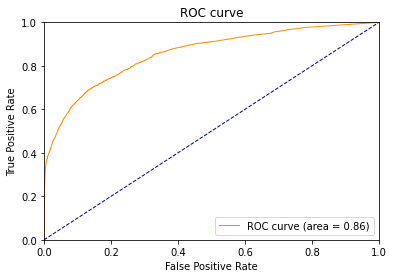

In [64]:
pred_proba_test = model.predict(x_valid)

fpr, tpr, thresholds = roc_curve(y_valid, pred_proba_test)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

__crossvalidation lgb__

In [18]:
cv_lgb_result = lgb.cv(
    params=params,
    train_set=dtrain,
    num_boost_round=200,
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=50,
    stratified=True,
    shuffle=True,
    nfold=3, 
)

[50]	cv_agg's auc: 0.872592 + 0.00236914
[100]	cv_agg's auc: 0.882894 + 0.00296531
[150]	cv_agg's auc: 0.892357 + 0.00296585
[200]	cv_agg's auc: 0.89713 + 0.00271269
[250]	cv_agg's auc: 0.902125 + 0.00302958
[300]	cv_agg's auc: 0.906159 + 0.00274758
[350]	cv_agg's auc: 0.910123 + 0.00176999
[400]	cv_agg's auc: 0.913192 + 0.00178553
[450]	cv_agg's auc: 0.915798 + 0.00183012
[500]	cv_agg's auc: 0.918225 + 0.0016458


In [19]:
cv_lgb_result = pd.DataFrame(cv_lgb_result)

In [20]:
cv_lgb_result.tail()

,auc-mean,auc-stdv
495,0.918091,0.001669
496,0.918120,0.001675
497,0.918154,0.001656
498,0.918191,0.001648
499,0.918225,0.001646


## Categorical features treatment

In [21]:
categorical_features = df_train.select_dtypes(include=[np.object])

In [22]:
categorical_features.head()

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,W,discover,credit,NaN,NaN,T,T,T,M2,F,T,NaN,NaN,NaN
1,W,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,W,visa,debit,outlook.com,NaN,T,T,T,M0,F,F,F,F,F
3,W,mastercard,debit,yahoo.com,NaN,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,H,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
from sklearn.preprocessing import LabelEncoder

In [24]:
def categorical_transformation(df):

  Product_CD_dict = {
    'W': 1, 
    'H': 2, 
    'C': 3, 
    'S': 4, 
    'R': 5}

  df['ProductCD_ord'] = df.ProductCD.map(Product_CD_dict)

  df['card4'] = df.card4.fillna('unknown')
  Card4_dict = {
    'discover': 1, 
    'mastercard': 2, 
    'visa': 3, 
    'american express': 4, 
    'unknown': 5
}
  df['card4_ord'] = df.card4.map(Card4_dict)

  df['card6'] = df.card6.fillna('unknown')
  Card6_dict = {
    'credit': 1, 
    'debit': 2, 
    'debit or credit': 3, 
    'charge card': 4, 
    'unknown': 5
}
  df['card6_ord'] = df.card6.map(Card6_dict)

  df['P_emaildomain'] = df.P_emaildomain.fillna('unknown')
  df['P_emaildomain_ord'] = LabelEncoder().fit_transform(df.P_emaildomain)

  df['R_emaildomain'] = df.R_emaildomain.fillna('unknown')
  df['R_emaildomain_ord'] = LabelEncoder().fit_transform(df.R_emaildomain)

  M_dict = {
    'F':0,
    'T':1,
    'unknown':-1
}
  M4_dict = {
    'M2':3,
    'M0':4,
    'unknown':6,
    'M1':5
}
  df['M4'] = df.M4.fillna('unknown')
  df['M4_ord'] = df.M4.map(M4_dict)

  M_features = ['M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9']
  for feature in M_features: 
    df[feature] = df[feature].fillna('unknown')
    df[feature + '_ord'] = df[feature].map(M_dict)
  
  upd_features = categorical_features.columns.to_list()
  upd_features = [i+'_ord' for i in categorical_features.columns.to_list()]

  return df[upd_features]

In [25]:
df_cat_train = categorical_transformation(df_train[categorical_features.columns.to_list()])

In [26]:
df_cat_test = categorical_transformation(df_test[categorical_features.columns.to_list()])

In [27]:
df_cat_train.head()

,ProductCD_ord,card4_ord,card6_ord,P_emaildomain_ord,R_emaildomain_ord,M1_ord,M2_ord,M3_ord,M4_ord,M5_ord,M6_ord,M7_ord,M8_ord,M9_ord
0,1,1,1,48,49,1,1,1,3,0,1,-1,-1,-1
1,1,2,1,16,49,-1,-1,-1,4,1,1,-1,-1,-1
2,1,3,2,35,49,1,1,1,4,0,0,0,0,0
3,1,2,2,54,49,-1,-1,-1,4,1,0,-1,-1,-1
4,2,2,1,16,49,-1,-1,-1,6,-1,-1,-1,-1,-1


In [28]:
df_cat_test.head()

,ProductCD_ord,card4_ord,card6_ord,P_emaildomain_ord,R_emaildomain_ord,M1_ord,M2_ord,M3_ord,M4_ord,M5_ord,M6_ord,M7_ord,M8_ord,M9_ord
0,1,3,1,2,45,1,1,0,4,1,0,0,0,1
1,1,3,2,54,45,-1,-1,-1,6,-1,1,-1,-1,-1
2,1,3,1,16,45,1,1,1,6,-1,1,0,0,1
3,1,3,2,1,45,1,1,1,4,1,1,0,1,1
4,1,3,2,1,45,1,1,1,6,-1,1,1,1,1


In [29]:
#добавим обработанные категориальные признаки к числовым и заново обучим модель.

In [35]:
num_list = numerical_features_train.columns.to_list()

In [37]:
df_cat_train_2 = df_train[num_list].join(df_cat_train)

In [39]:
df_cat_test_2 = df_test[num_list].join(df_cat_test)

In [40]:
y_train_cat = df_train["isFraud"]
x_train_cat = df_cat_train_2.drop(["isFraud"], axis = 1)

y_valid_cat = df_test["isFraud"]
x_valid_cat = df_cat_test_2.drop(["isFraud"], axis = 1)

In [41]:
dtrain_cat = lgb.Dataset(x_train_cat, y_train_cat)
dtest_cat = lgb.Dataset(x_valid_cat, y_valid_cat)

In [42]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 1000,
    "seed": 27
}

In [43]:
model_cat = lgb.train(
    params=params,
    train_set=dtrain_cat,
    num_boost_round=1000,
    valid_sets=[dtrain_cat, dtest_cat],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=50
)

Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.880689	valid_1's auc: 0.850816
[100]	training's auc: 0.890965	valid_1's auc: 0.857321
[150]	training's auc: 0.903987	valid_1's auc: 0.862404
[200]	training's auc: 0.915141	valid_1's auc: 0.864414
[250]	training's auc: 0.924149	valid_1's auc: 0.865717
[300]	training's auc: 0.93253	valid_1's auc: 0.866922
[350]	training's auc: 0.938773	valid_1's auc: 0.867728
[400]	training's auc: 0.943754	valid_1's auc: 0.868377
[450]	training's auc: 0.947511	valid_1's auc: 0.868758
[500]	training's auc: 0.950896	valid_1's auc: 0.869375
[550]	training's auc: 0.95412	valid_1's auc: 0.870599
[600]	training's auc: 0.956958	valid_1's auc: 0.871245
[650]	training's auc: 0.959159	valid_1's auc: 0.871756
[700]	training's auc: 0.961385	valid_1's auc: 0.871922
[750]	training's auc: 0.963305	valid_1's auc: 0.872391
[800]	training's auc: 0.964798	valid_1's auc: 0.87255
Early stopping, best iteration is:
[796]	training's auc: 0.964

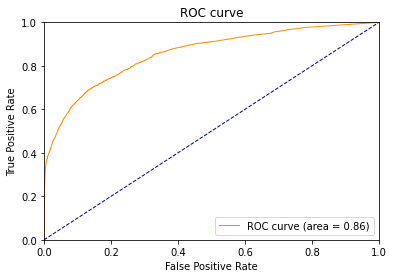

In [65]:
pred_proba_test_cat = model_cat.predict(x_valid_cat)

fpr, tpr, thresholds = roc_curve(y_valid_cat, pred_proba_test)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [44]:
# Выводы: 
# - обработанные категориальные призаки дают существенный прирост в качестве (на трейне до - 0.89, после - 0.96)
# - количество итераций также увеличилось до 1000. Останов получили на 796 итерации

__cross validation lgb (cat + num)__


In [45]:
cv_lgb_result_cat = lgb.cv(
    params=params,
    train_set=dtrain_cat,
    num_boost_round=200,
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=50,
    stratified=True,
    shuffle=True,
    nfold=3, 
)

[50]	cv_agg's auc: 0.87533 + 0.00504322
[100]	cv_agg's auc: 0.886273 + 0.00450188
[150]	cv_agg's auc: 0.895248 + 0.00332884
[200]	cv_agg's auc: 0.902593 + 0.00305997
[250]	cv_agg's auc: 0.908398 + 0.00357984
[300]	cv_agg's auc: 0.913411 + 0.00339376
[350]	cv_agg's auc: 0.917843 + 0.00291077
[400]	cv_agg's auc: 0.92102 + 0.00314796
[450]	cv_agg's auc: 0.923724 + 0.00301969
[500]	cv_agg's auc: 0.926008 + 0.00286477
[550]	cv_agg's auc: 0.928336 + 0.00291943
[600]	cv_agg's auc: 0.930662 + 0.00279885
[650]	cv_agg's auc: 0.932467 + 0.00282767
[700]	cv_agg's auc: 0.933834 + 0.00277691
[750]	cv_agg's auc: 0.935024 + 0.0027811
[800]	cv_agg's auc: 0.936153 + 0.00283721
[850]	cv_agg's auc: 0.937137 + 0.00284917
[900]	cv_agg's auc: 0.93804 + 0.0028884
[950]	cv_agg's auc: 0.938916 + 0.00301912
[1000]	cv_agg's auc: 0.939785 + 0.00308978


In [46]:
cv_lgb_result_cat = pd.DataFrame(cv_lgb_result_cat)

In [47]:
cv_lgb_result_cat.tail()

,auc-mean,auc-stdv
995,0.939725,0.003090
996,0.939728,0.003089
997,0.939754,0.003089
998,0.939771,0.003077
999,0.939785,0.003090


In [48]:
# Выводы: 
# - значительно лучше CV при обработанных категориальных признаках.
#499	0.918225	0.001646 (без обработки)
#999	0.939785	0.003090 (с обработкой)

## Обработать категориальные признаки встроенным методом в LightGBM. Выполнить задание 4. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 5.

In [49]:
dtrain_cat_lgb = lgb.Dataset(data=x_train_cat, label=y_train_cat, categorical_feature=df_cat_train.columns.to_list())
dvalid_cat_lgb = lgb.Dataset(data=x_valid_cat, label=y_valid_cat, categorical_feature=df_cat_train.columns.to_list())

In [50]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 1000,
    "seed": 27
}

In [51]:
model_lgb_cat = lgb.train(
    params=params,
    train_set=dtrain_cat_lgb,
    num_boost_round=1000,
    valid_sets=[dtrain_cat_lgb, dvalid_cat_lgb],
    categorical_feature=df_cat_train.columns.to_list(),
    early_stopping_rounds=50,
    verbose_eval=50
)

Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.885508	valid_1's auc: 0.854021
[100]	training's auc: 0.89922	valid_1's auc: 0.859234
[150]	training's auc: 0.910044	valid_1's auc: 0.862859
[200]	training's auc: 0.917717	valid_1's auc: 0.865227
[250]	training's auc: 0.927396	valid_1's auc: 0.86834
[300]	training's auc: 0.933756	valid_1's auc: 0.870252
[350]	training's auc: 0.939811	valid_1's auc: 0.872224
[400]	training's auc: 0.944176	valid_1's auc: 0.872925
[450]	training's auc: 0.947959	valid_1's auc: 0.873856
[500]	training's auc: 0.952687	valid_1's auc: 0.874377
[550]	training's auc: 0.955805	valid_1's auc: 0.874544
[600]	training's auc: 0.958905	valid_1's auc: 0.875121
[650]	training's auc: 0.961234	valid_1's auc: 0.875259
[700]	training's auc: 0.963369	valid_1's auc: 0.875257
[750]	training's auc: 0.965341	valid_1's auc: 0.876097
Early stopping, best iteration is:
[745]	training's auc: 0.965189	valid_1's auc: 0.876156


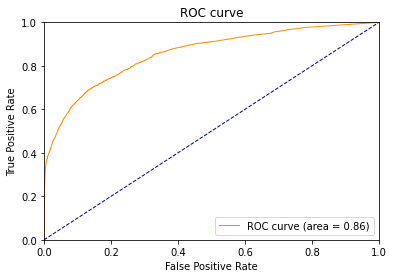

In [66]:
pred_proba_test_cat2 = model_lgb_cat.predict(x_valid_cat)

fpr, tpr, thresholds = roc_curve(y_valid_cat, pred_proba_test)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [52]:
#Результаты в сравнении с предыдущим этапом:
# 4 [796]	training's auc: 0.964694	valid_1's auc: 0.872671
# 5 [745]	training's auc: 0.965189	valid_1's auc: 0.876156
# как мы видим результат чуть лучше, чем на этапе 4. Следовательно, предпочтительнее подавать в lgb категориальные фичи через обработчик. 

In [53]:
cv_lgb_result_cat_2 = lgb.cv(
    params=params,
    train_set=dtrain_cat_lgb,
    num_boost_round=200,
    categorical_feature=df_cat_train.columns.to_list(),
    early_stopping_rounds=50,
    verbose_eval=50,
    stratified=True,
    shuffle=True,
    nfold=3, 
)

[50]	cv_agg's auc: 0.87725 + 0.00291749
[100]	cv_agg's auc: 0.892177 + 0.00367384
[150]	cv_agg's auc: 0.900159 + 0.00322825
[200]	cv_agg's auc: 0.906387 + 0.00334508
[250]	cv_agg's auc: 0.911115 + 0.00278333
[300]	cv_agg's auc: 0.915368 + 0.0034532
[350]	cv_agg's auc: 0.919152 + 0.00324908
[400]	cv_agg's auc: 0.922637 + 0.00375217
[450]	cv_agg's auc: 0.925408 + 0.00369122
[500]	cv_agg's auc: 0.927709 + 0.00366197
[550]	cv_agg's auc: 0.93008 + 0.00402265
[600]	cv_agg's auc: 0.931897 + 0.00389439
[650]	cv_agg's auc: 0.933478 + 0.00384723
[700]	cv_agg's auc: 0.934951 + 0.00395559
[750]	cv_agg's auc: 0.935963 + 0.00392352
[800]	cv_agg's auc: 0.937134 + 0.00412
[850]	cv_agg's auc: 0.938051 + 0.00427448
[900]	cv_agg's auc: 0.938815 + 0.00419515
[950]	cv_agg's auc: 0.9395 + 0.00423875
[1000]	cv_agg's auc: 0.940191 + 0.00421355


In [54]:
cv_lgb_result_cat_2 = pd.DataFrame(cv_lgb_result_cat_2)

In [55]:
cv_lgb_result_cat_2.tail()

,auc-mean,auc-stdv
995,0.940133,0.004197
996,0.940143,0.004189
997,0.940168,0.004213
998,0.940182,0.004217
999,0.940191,0.004214


In [56]:
# Выводы: 
# - значительно лучше CV при обработанных категориальных признаках.
#499	0.918225	0.001646 (без обработки)
#999	0.939785	0.003090 (с обработкой)
#999	0.940191	0.004214 (c подачей в lgb обработчик)

In [67]:
# Задание 10
# Для всех трех случаев получили устойчивый Roc-auc = 0.86. По сравнению с CV это удивляет, поскольку на кросс-валидации показатель улучшался. 